In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import seaborn as sns

Plan of working: 
1. Find the way to extract all the restaurants and all the categories related to that. - DONE
2. Count the number of tips related to one restaurant.  - DONE
3. Count the number of checkins that are done for one place. - DONE
4. Do the correlation analysis for both Pearson and Spierman Coefficients: 1) Correlation matrices; 2) Scatter plots
(4 plots) - DONE
5. Perform PCA, plot the scree plot, identify the number of key components - DONE

In [2]:
data = pd.read_json('/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/CW2/yelp_academic_dataset_business.json', lines=True)

In [3]:
data = data.loc[data['state'] == 'AZ'] #locking only entries related to the specific state
# categories = data['categories'].unique() #checking for the unique categories
data = data.where(data['categories'].str.contains('Restaurants') == True).dropna() #only living the values that contain category 'Restaurants'

In [4]:
tips = pd.read_json('/Users/user/Desktop/UCL_CS_Masters/datascience/Courseworks/CW1/yelp_dataset/yelp_academic_dataset_tip.json', lines=True)

In [5]:
# Count the number of reviews
tips_counts = pd.DataFrame(tips['business_id'].value_counts()).reset_index()
tips_counts = tips_counts.rename(columns={'index': 'business_id', 'business_id': 'tips_count'})
# Merging the dataset with tips
data = pd.merge(data, tips_counts, on='business_id')

In [7]:
checkins = pd.read_json('/Users/user/Desktop/UCL_CS_Masters/datascience/Courseworks/CW1/yelp_dataset/yelp_academic_dataset_checkin.json', lines=True)

In [205]:
# checkins['date'].str.extract(r'(2[0-3]|[01][0-9]|[0-9]):([0-5][0-9]|[0-9]):([0-5][0-9]|[0-9])')
checkins['date'] = checkins['date'].str.split(",")

In [21]:
checks = checkins['date'].str.split(",")
checks_int = [len(checks[index]) for index in range(len(checks))] #create a list of count
checkins['checks_int'] = checks_int #assign checks int as a column of database
checkins = checkins.drop(['date'], axis=1) #drop the date column
data = pd.merge(data, checkins, on='business_id') #merge with the dataset 

['2016-07-08 16:43:30']

In [31]:
# Preparing data for correlation analysis
data_corr = data.drop(['latitude', 'longitude', 'is_open', 'stars'], axis=1)


In [33]:
data_corr.corr(method = 'pearson')

,review_count,tips_count,checks_int
review_count,1.000000,0.887146,0.810789
tips_count,0.887146,1.000000,0.873767
checks_int,0.810789,0.873767,1.000000


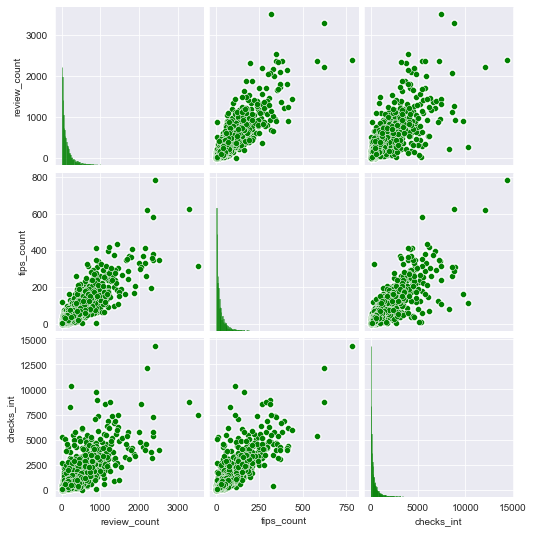

In [65]:
# Pairgrid of the numerical values 
sns.set_style("darkgrid")
sns.color_palette("Set2", 8, .75)
sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
g = sns.pairplot(data_corr, 
                 plot_kws=dict(palette="ch:s=-.2,r=.6", linewidth=2), 
                diag_kws=dict(fill=False, color='green'))
g.map_upper(sns.scatterplot,color="green")
g.map_lower(sns.scatterplot, color='green')
g.savefig("/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/star-predictions/artworks/corr_scatters.png")

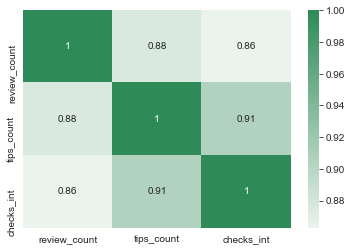

In [78]:
cmap = sns.light_palette("seagreen", as_cmap=True)
pearson = sns.heatmap(data_corr.corr(method = 'pearson'), cmap=cmap, annot=True)
corr_pearson = pearson.get_figure()
corr_pearson.savefig("/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/star-predictions/artworks/corr_pearson.png")
spearman = sns.heatmap(data_corr.corr(method = 'spearman'), cmap=cmap, annot=True)
corr_spearman = spearman.get_figure()
corr_spearman.savefig("/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/star-predictions/artworks/corr_spearman.png")



In [181]:
# Permutation test 
reviews_tips_spearman = []
reviews_checkins_spearman = []
tips_checkins_spearman = []
inter = 0
while inter < 500:
    inter = inter + 1
    reviews_reshuffled = data_corr['review_count'].sample(n=9269)
    tips_reshuffled = data_corr['tips_count'].sample(n=9269)
    checkin_reshuffled = data_corr['checks_int'].sample(n=9269)
    reviews_tips_spearman.append(scipy.stats.spearmanr(reviews_reshuffled, tips_reshuffled)[0])
    reviews_checkins_spearman.append(scipy.stats.spearmanr(reviews_reshuffled, checkin_reshuffled)[0])
    tips_checkins_spearman.append(scipy.stats.spearmanr(tips_reshuffled, checkin_reshuffled)[0])

In [182]:
# Permutation test 
reviews_tips_pearson = []
reviews_checkins_pearson = []
tips_checkins_pearson = []
inter = 0
while inter < 500:
    inter = inter + 1
    reviews_reshuffled = data_corr['review_count'].sample(n=9269)
    tips_reshuffled = data_corr['tips_count'].sample(n=9269)
    checkin_reshuffled = data_corr['checks_int'].sample(n=9269)
    reviews_tips_pearson.append(scipy.stats.pearsonr(reviews_reshuffled, tips_reshuffled)[0])
    reviews_checkins_pearson.append(scipy.stats.pearsonr(reviews_reshuffled, checkin_reshuffled)[0])
    tips_checkins_pearson.append(scipy.stats.pearsonr(tips_reshuffled, checkin_reshuffled)[0])

In [191]:
d = {'reviews_tips_pearson':reviews_tips_pearson, 'reviews_checkins_pearson':reviews_checkins_pearson, 'tips_checkins_pearson':tips_checkins_pearson, 'reviews_tips_spearman':reviews_tips_spearman, 'reviews_checkins_spearman':reviews_checkins_spearman, 'tips_checkins_spearman':tips_checkins_spearman}
correlations = pd.DataFrame(data=d)

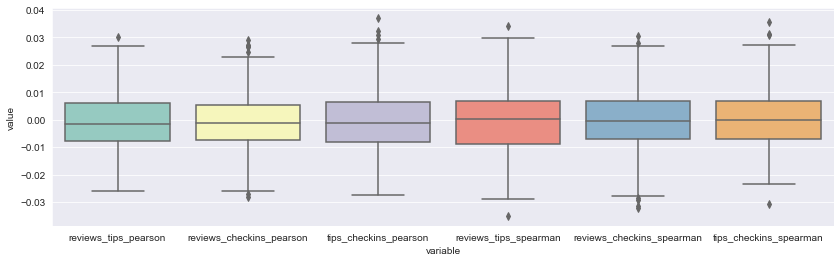

In [205]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,4))
correlations_plot = sns.boxplot(x='variable', y='value',data=pd.melt(correlations), orient='v', palette="Set3", )
# correlations.plot(data_corr.corr(method = 'pearson'), 'o')
# # correlations.set_xlim([-1, 1])
# correlations.set_ylim([-0.1, 1])
# correlations_plot.set_xticks(,{'fontsize':'x-small'})
corr_pearson = correlations_plot.get_figure()
corr_pearson.savefig("/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/star-predictions/artworks/boxplot_corr.png")

In [252]:
# PCA for the original data 
data_pca = data[['review_count', 'tips_count','checks_int', 'is_open', 'city', 'categories' ]]

In [259]:
numerical_cols = data_pca.select_dtypes(include=['int', 'float'])
categorical_cols = data_pca.select_dtypes(include=['object'])

In [296]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_var = pd.DataFrame(col_transform.fit_transform(data_pca))


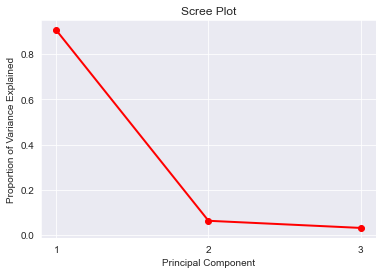

In [220]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xticks([1,2,3])

plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [222]:
pca.explained_variance_/3

array([0.90506158, 0.06328114, 0.03176517])

In [223]:
pca.components_

array([[ 0.57373712,  0.58754824,  0.5706249 ],
       [-0.66976048, -0.06445019,  0.73977501],
       [ 0.47143039, -0.8066184 ,  0.35653913]])

In [305]:
# PCA Regression 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
X_train, X_test, y_train, y_test = train_test_split(data_pca,data['stars'], random_state=1)
pcr = make_pipeline(col_transform, TruncatedSVD(n_components=5), LinearRegression())
pcr.fit(X_train, y_train)

print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")

PCR r-squared 0.088


In [306]:
pcr['truncatedsvd'].explained_variance_ratio_

array([0.47483639, 0.16501983, 0.03836815, 0.03137787, 0.0211007 ])

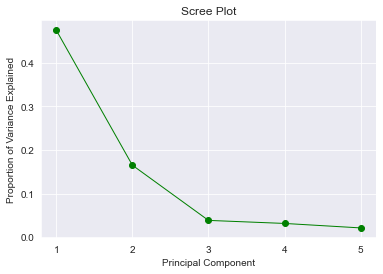

In [311]:
PC_values = np.arange(len(pcr['truncatedsvd'].explained_variance_ratio_)) + 1
plt.plot(PC_values, pcr['truncatedsvd'].explained_variance_ratio_, 'go-', linewidth=1)
plt.title('Scree Plot')
plt.xticks([1,2,3,4,5])

plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
# plt.show()
plt.savefig("/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/star-predictions/artworks/scree_plot_pca.png")

In [271]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Building (data preprocessing pipeline) the column transformer 
num_pipeline = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

col_transform = ColumnTransformer([
    ('cat', categorical_transformer, ['categories', 'city']),
    ('num', num_pipeline, ['review_count', 'tips_count', 'checks_int', 'is_open'])
])

In [247]:
y, X = dmatrices('stars ~ review_count + is_open + city', data=data, return_type='dataframe')

In [105]:
import scipy.stats
scipy.stats.pearsonr(data_corr['review_count'], data_corr['tips_count'])

0.8871455921126502

In [248]:
mod = sm.OLS(y, X)    # Describe model

res = mod.fit()       # Fit model

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     20.59
Date:                Sun, 04 Apr 2021   Prob (F-statistic):          7.55e-163
Time:                        20:21:32   Log-Likelihood:                -10607.
No. Observations:                9269   AIC:                         2.131e+04
Df Residuals:                    9221   BIC:                         2.165e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [249]:
data

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,tips_count,checks_int
0,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.602822,-111.983533,4.0,10.0,1.0,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","Food, Pretzels, Bakeries, Fast Food, Restaurants","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",4,24
1,Ga2Bt7xfqoggTypWD5VpoQ,Amando's Bros,2602 W Southern Ave,Tempe,AZ,85282,33.393199,-111.976270,4.0,9.0,0.0,"{'Caters': 'False', 'RestaurantsGoodForGroups'...","Mexican, Restaurants","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",5,43
2,j9bWpCRwpDVfwVT_V85qeA,Papaya Thai,2706 E University Dr,Mesa,AZ,85213,33.423705,-111.772890,2.5,130.0,1.0,"{'Caters': 'False', 'OutdoorSeating': 'False',...","Food, Ethnic Food, Specialty Food, Restaurants...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",16,110
3,W7hCuNdn2gzehta6eSHzgQ,Pete's Fish & Chips,1017 E Apache Blvd,Tempe,AZ,85281,33.414507,-111.923721,2.0,117.0,1.0,"{'NoiseLevel': 'u'average'', 'BusinessAcceptsC...","Restaurants, Fish & Chips, Seafood","{'Monday': '10:30-22:0', 'Tuesday': '10:30-22:...",16,150
4,8nP8ghEpT6WFcM6tfqAaGA,Sugar Bowl,4005 N Scottsdale Rd,Scottsdale,AZ,85251,33.493775,-111.925933,3.5,720.0,1.0,"{'RestaurantsAttire': ''casual'', 'Alcohol': '...","Ice Cream & Frozen Yogurt, Sandwiches, Food, A...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",97,2189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9264,GPJAacvrxZpbJvJiYvWitQ,Taco Bell,6728 Main St,Mesa,AZ,85205,33.415539,-111.686111,3.0,8.0,1.0,"{'Alcohol': 'u'none'', 'Ambience': '{'romantic...","Restaurants, Tex-Mex, Fast Food, Mexican","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",3,50
9265,EDa7_YfEB2HDOyxDMbipQA,Barro's Pizza,15475 W Mcdowell Rd,Goodyear,AZ,85338,33.462607,-112.391739,3.5,157.0,1.0,"{'RestaurantsDelivery': 'True', 'HasTV': 'True...","Italian, Sandwiches, Pizza, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:30-21:0',...",21,272
9266,_bvc2j6E8mk_ZiMoh2iMuQ,Sonic Drive-In,6501 W Glendale Ave,Glendale,AZ,85301,33.537861,-112.199338,2.5,13.0,1.0,"{'BusinessAcceptsCreditCards': 'True', 'Alcoho...","Ice Cream & Frozen Yogurt, Burgers, Restaurant...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",6,99
9267,cmsAFAymfVoBitSF8R6GKw,Yao Fine Chinese Cuisine,"2487 S Gilbert Rd, Ste 102",Gilbert,AZ,85295,33.304935,-111.788861,4.0,230.0,1.0,"{'RestaurantsGoodForGroups': 'True', 'Ambience...","Chinese, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",40,419


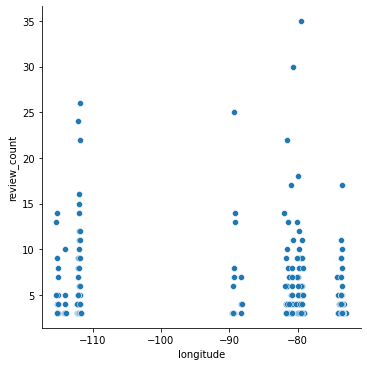

In [62]:
sns.relplot(x="longitude", y="review_count", palette="ch:r=-.5,l=.75", data=data.loc[data['categories'] == 'Restaurants']);